In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, desc, avg, year, length, split, explode, udf
from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.sql.functions import explode

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/DESProject
!ls /content/drive/MyDrive/DESProject/spark-3.5.2-bin-hadoop3.tgz
!tar xf /content/drive/MyDrive/DESProject/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"

books_data.csv	   data_engg_books_data_from_valid_categories.csv	spark-3.5.2-bin-hadoop3.tgz
Books_rating.csv   data_engg_books_rating_from_valid_categories_df.csv
ConvToSpark.ipynb  sampled_book_df.csv
/content/drive/MyDrive/DESProject/spark-3.5.2-bin-hadoop3.tgz


In [4]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Amazon_book_reviews_project")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()

In [5]:
books_data_df = spark.read.csv('/content/drive/MyDrive/DESProject/books_data.csv', header=True, inferSchema=True)
books_rating_df = spark.read.csv('/content/drive/MyDrive/DESProject/Books_rating.csv', header=True, inferSchema=True)


In [ ]:
books_data_df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- image: string (nullable = true)
 |-- previewLink: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- infoLink: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- ratingsCount: string (nullable = true)



In [ ]:
books_rating_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)



# Data Preparation

In [6]:
print("Books Data Count:", books_data_df.count())
print("Books Rating Data Count:", books_rating_df.count())

Books Data Count: 212404
Books Rating Data Count: 3000000


# Checking for Null/empty values of Books data df

In [7]:
null_counts_books_data = books_data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in books_data_df.columns]).collect()[0].asDict()
print("Null counts for books_data_df:")
for col_name, null_count in null_counts_books_data.items():
    print(f"{col_name} : {null_count}")

Null counts for books_data_df:
Title : 1
description : 68357
authors : 31251
image : 51191
previewLink : 24055
publisher : 73130
publishedDate : 25844
infoLink : 24301
categories : 40524
ratingsCount : 148552


# Inspecting important columns of books_data_df
The columns of interest in books_data df are
1. ratingsCount
2. catgeories
3. Title
4. Publisher
5. publishedDate

All of these columns should have proper values. The rows having invalid values ffor these columns should be eliminated as they will not be helping us to extract any meaningful information

In [8]:
null_counts_books_data = books_data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in books_data_df.columns]).collect()[0].asDict()
print("Null counts for books_data_df:")
for col_name, null_count in null_counts_books_data.items():
    print(f"{col_name} : {null_count}")

Null counts for books_data_df:
Title : 1
description : 68357
authors : 31251
image : 51191
previewLink : 24055
publisher : 73130
publishedDate : 25844
infoLink : 24301
categories : 40524
ratingsCount : 148552


In [6]:
# Number of ratings_count_columns having invalid values
invalid_ratings_count = books_data_df.filter(~col("ratingsCount").rlike("^[0-9]*\\.?[0-9]+$")).count()
invalid_ratings_count

20426

In [7]:
# Replacing all non-numeric invalid values with None
books_data_df = books_data_df.withColumn("ratingsCount", when(col("ratingsCount").rlike("^[0-9]*\\.?[0-9]+$"), col("ratingsCount")).otherwise(0.0))
# Cast ratingsCount to float
books_data_df = books_data_df.withColumn("ratingsCount", col("ratingsCount").cast("float"))
# filling zeros which have None values for ratings count
books_data_df = books_data_df.fillna({"ratingsCount": 0.0})

# Cleaning categories column
Ideally categories column should be of array type containing list of categories. In the given dataset it has type string and many records contain invalid values.
The below UDF converts it to a valid array and for those records which invalid values, it replaces them with an empty array

In [8]:
import ast
def convert_string_to_list(col_value):
    transformed_val = []
    if isinstance(col_value, str):
        try:
            transformed_val = ast.literal_eval(col_value)
        except:
            transformed_val = []
    return transformed_val

convert_string_to_list_udf = udf(convert_string_to_list, ArrayType(StringType()))

In [9]:
books_data_df = books_data_df.withColumn("categories", convert_string_to_list_udf(books_data_df["categories"]))
books_data_df.select(col('publisher')).show()

+--------------------+
|           publisher|
+--------------------+
|                NULL|
| inspiring artist...|
|                NULL|
|           iUniverse|
|                NULL|
|Wm. B. Eerdmans P...|
|                NULL|
|                NULL|
|     Tan Books & Pub|
|  Plympton PressIntl|
|    Berg Pub Limited|
|                NULL|
|            Sky Pony|
|               audio|
|Pickle Partners P...|
|                NULL|
|Bloomsbury Publis...|
|['Rochelle Gurste...|
|              Bantam|
| there are more t...|
+--------------------+
only showing top 20 rows



In [10]:
exploded_df = books_data_df.select("Title", explode("categories").alias("category"))
category_counts = exploded_df.groupBy("category").count().orderBy("count", ascending=False)
rows = category_counts.collect()
category_names = []
counts = []
for row in rows:
    if (row['category'] != '' or row['category'] is not None) and row['count'] >= 1000:
        category_names.append(row['category'])
        counts.append(row['count'])
print(str(category_names))
print('-------------------------------')
print(str(counts))

['Fiction', 'Religion', 'History', 'Juvenile Fiction', 'Biography & Autobiography', 'Business & Economics', 'Computers', 'Social Science', 'Juvenile Nonfiction', 'Science', 'Education', 'Cooking', 'Sports & Recreation', 'Medical', 'Music', 'Family & Relationships', 'Art', 'Literary Criticism', 'Language Arts & Disciplines', 'Health & Fitness', 'Body, Mind & Spirit', 'Political Science', 'Psychology', 'Travel', 'Philosophy', 'Technology & Engineering', 'Foreign Language Study', 'Crafts & Hobbies', 'Self-Help', 'Poetry', 'Reference', 'Performing Arts', 'Mathematics', 'Comics & Graphic Novels', 'Nature']
-------------------------------
[20020, 7923, 7882, 6088, 5207, 4663, 3659, 3212, 3190, 2346, 2297, 2158, 1975, 1828, 1823, 1814, 1796, 1791, 1751, 1726, 1705, 1611, 1588, 1586, 1541, 1492, 1278, 1229, 1180, 1167, 1149, 1102, 1042, 1032, 1028]


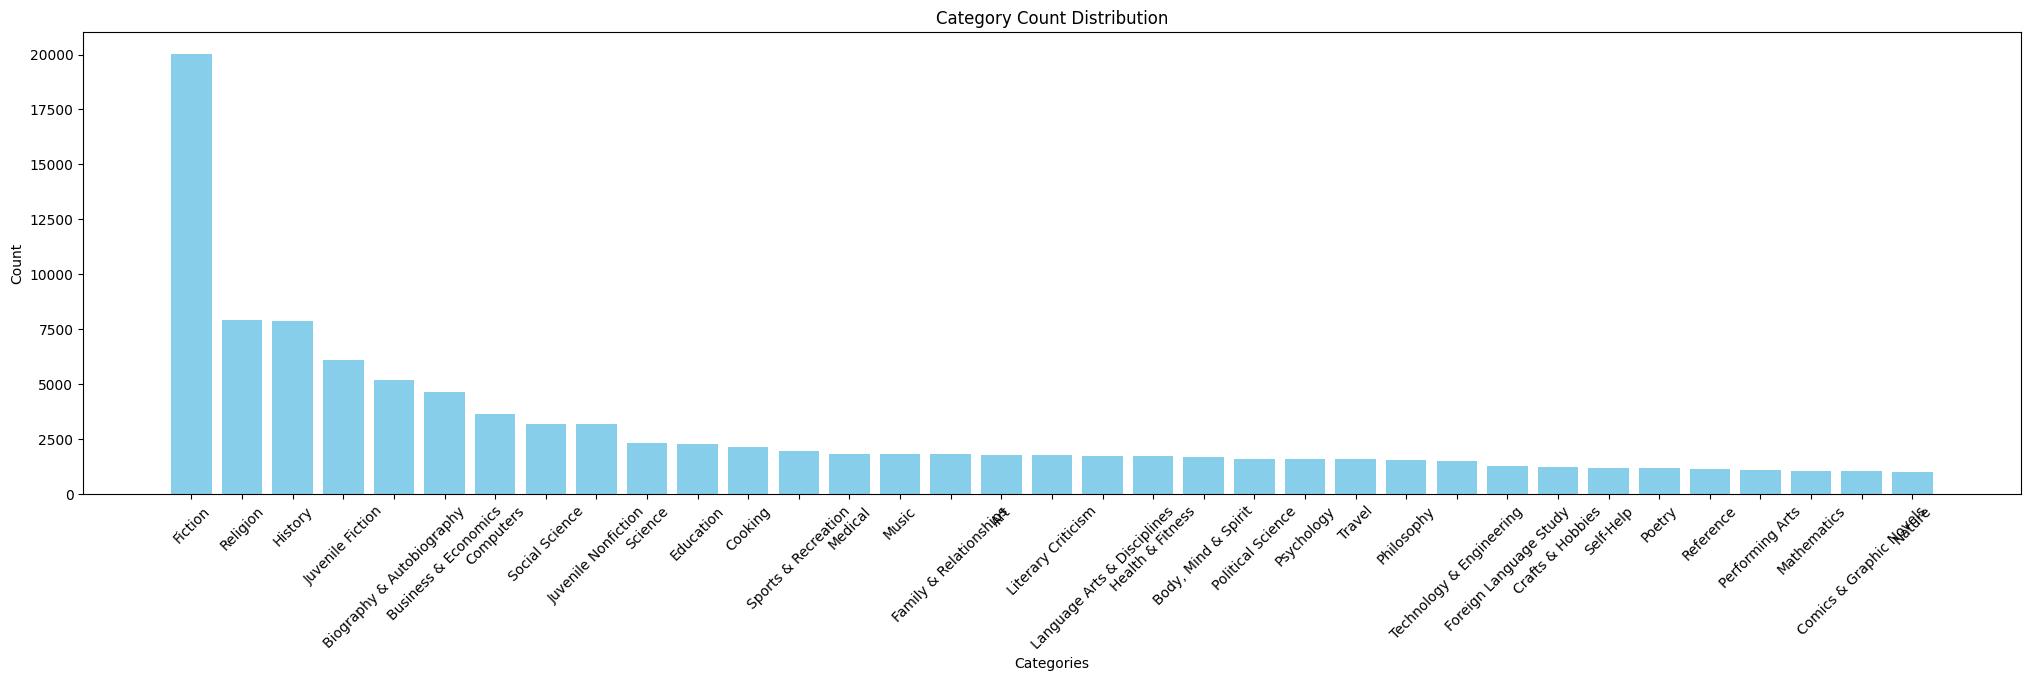

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 6))
plt.bar(category_names, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Category Count Distribution')
plt.xticks(rotation=45)
plt.show()

# Cleaning Title column
Finding out how many rows have title column empty. These should be dropped because any information pertaining to a book which has no information about the title present is totally irrelvant.

In [15]:
count_before_dropping_null_titles = books_data_df.count()
books_data_df.na.drop(subset=['Title'])
count_after_dropping_null_titles = books_data_df.count()
print(f"row count before dropping null titles: {count_before_dropping_null_titles}, row count after dropping null titles: {count_after_dropping_null_titles}")

row count before dropping null titles: 212404, row count after dropping null titles: 212404


## Therefore, no record has empty title in books_data_df

Cleaning the Publisher column
Changing all links to none

In [11]:
from pyspark.sql.functions import when, col

books_data_df = books_data_df.withColumn(
    "publisher",
    when(col("publisher").startswith("http://books.google"), None).otherwise(col("publisher"))
)

books_data_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+
|               Title|         description|             authors|               image|         previewLink|           publisher|       publishedDate|            infoLink|          categories|ratingsCount|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+
|Its Only Art If I...|                NULL|    ['Julie Strain']|http://books.goog...|http://books.goog...|                NULL|                1996|http://books.goog...|[Comics & Graphic...|         0.0|
|Dr. Seuss: Americ...|"Philip Nel takes...| like that of Lew...| has changed lang...| giving us new wo...| inspiring artist...|      ['Philip Nel']|http://books.goog...|               

Cleaning the publishDate column

In [12]:
from pyspark.sql.functions import regexp_replace, col, when

valid_year_pattern = r"^\d{4}$"
valid_date_pattern = r"^\d{4}-\d{1,2}-\d{1,2}$"

books_data_df = books_data_df.withColumn(
    "publishedDate",
    when(col("publishedDate").rlike(valid_year_pattern) | col("publishedDate").rlike(valid_date_pattern), col("publishedDate"))
    .otherwise(None)  # Replace invalid formats with NULL
)

books_data_df.select("publishedDate").show(50)

+-------------+
|publishedDate|
+-------------+
|         1996|
|         NULL|
|         2000|
|         NULL|
|   2003-03-01|
|         1996|
|         1960|
|         1988|
|   2009-01-01|
|         1995|
|   1994-02-17|
|         NULL|
|   2018-11-06|
|         NULL|
|   2018-02-27|
|         2009|
|   2010-01-28|
|         NULL|
|   2012-02-01|
|         NULL|
|   2011-07-27|
|   2015-06-15|
|   2000-04-26|
|         NULL|
|         NULL|
|         1989|
|   2008-04-15|
|         1888|
|   2012-02-07|
|   2020-09-25|
|         NULL|
|   2012-08-21|
|   1976-01-01|
|   2018-09-20|
|         1954|
|         NULL|
|         NULL|
|   2012-03-02|
|         NULL|
|         NULL|
|         NULL|
|         2013|
|         NULL|
|         NULL|
|         NULL|
|   2003-10-10|
|         1864|
|   1981-09-01|
|         1982|
|         1997|
+-------------+
only showing top 50 rows



# Inspecting important columns of books_rating_df

The columns of interest in books_rating_df are

1. Title
2. Price
3. review/helpfulness
4. review/score
5. review/time
6. review/summary
7. review/text

All of these columns are of type string. But since review/score , review/helpfulness are essentially scores. we should normalize and/or scale them to some meaningful Range.

But first, lets check the number of empty values in each column of books_rating_df

In [13]:
null_counts_books_rating = books_rating_df.select([count(when(col(c).isNull(), c)).alias(c) for c in books_rating_df.columns]).collect()[0].asDict()
print("\nNull counts for books_rating_df:")
for col_name, null_count in null_counts_books_rating.items():
    print(f"{col_name} : {null_count}")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

# Normalizing review/score column of books_rating_df

1. Scaled all values in the 0-5 range
2. Values which are null or invalid have been replaced with 0.0

In [14]:

def normalize_fraction(s, index_of_divide_operator):
    try:
        if index_of_divide_operator > -1:
            numerator = float(s[:index_of_divide_operator].strip())
            denominator = float(s[index_of_divide_operator+1:].strip())
            return (numerator * 5/ denominator) if denominator > 0.0 else 0.0
        else:
            return 0.0
    except:
        return 0.0

def convert_string_to_float(val):
    if val is not None and isinstance(val, float) and val >=0 and val <=5:
        return val
    float_val = 0.0
    if val is not None and isinstance(val, str):
        try:
            float_val = float(val)
            float_val = float_val if float_val >=0 and float_val <=5 else 0.0
        except:
            index_of_divide_operator = val.find('/')
            float_val = normalize_fraction(val, index_of_divide_operator)
    return float_val

normalize_string_to_float_udf = udf(convert_string_to_float, FloatType())



#def normalize_fraction(s, index_of_divide_operator):
#    try:
#        if index_of_divide_operator > -1:
#            numerator = float(s[:index_of_divide_operator].strip())
#            denominator = float(s[index_of_divide_operator+1:].strip())
#            return (numerator * 5 / denominator) if denominator > 0.0 else 0.0
#        else:
#            return 0.0
#    except:
#        return 0.0

#def round_to_nearest_half(value):

#    if value < 0 or value > 5:
#        return 0.0
#    return round(value * 2) / 2

#def convert_string_to_float_and_round(val):

#    float_val = 0.0
#    if val is not None and isinstance(val, float) and 0 <= val <= 5:
#        return round_to_nearest_half(val)
#    if val is not None and isinstance(val, str):
#        try:
#            float_val = float(val)
#        except:
#            index_of_divide_operator = val.find('/')
#            float_val = normalize_fraction(val, index_of_divide_operator)
#    return round_to_nearest_half(float_val)

#normalize_string_to_float_udf = udf(convert_string_to_float_and_round, FloatType())


In [ ]:
books_rating_df.select("review/score").show(50)

+------------+
|review/score|
+------------+
|         4.0|
|         5.0|
|         5.0|
|         4.0|
|         4.0|
|         4.0|
|         5.0|
|         5.0|
|         5.0|
|         4.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         1.0|
|         4.0|
|         1.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         4.0|
|         1.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         4.0|
|         5.0|
|         4.0|
|         5.0|
|         5.0|
|         1.0|
|         1.0|
|         1.0|
|         1.0|
|         1.0|
|         4.0|
|         5.0|
|         5.0|
|         1.0|
|         5.0|
|         5.0|
|         5.0|
|         4.0|
+------------+
only showing top 50 rows



In [15]:
books_rating_df = books_rating_df.withColumn("review/score", normalize_string_to_float_udf(books_rating_df["review/score"]))
books_rating_df.select(col('review/score')).show()
books_rating_df.printSchema()
null_counts_books_review_score = books_rating_df.select(count(when(col('review/score').isNull(), 'review/score')).alias('Num of Null values in review/score column'))
null_counts_books_review_score.show()
hist_data = books_rating_df.select("review/score").rdd.flatMap(lambda x: x).histogram([0, 1, 2, 3, 4, 5])

# Display bin counts
review_score_bin_ranges = hist_data[0]
review_score_counts = hist_data[1]

# Show results in tabular form
for i in range(len(review_score_counts)):
    print(f"Bin {review_score_bin_ranges[i]} to {review_score_bin_ranges[i+1]}: Count = {review_score_counts[i]}")


+------------+
|review/score|
+------------+
|         4.0|
|         5.0|
|         5.0|
|         4.0|
|         4.0|
|         4.0|
|         5.0|
|         5.0|
|         5.0|
|         4.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         1.0|
|         4.0|
|         1.0|
|         5.0|
|         5.0|
|         5.0|
+------------+
only showing top 20 rows

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

+-----------------------------------------+
|Num of Null values in review/score column|
+-----------------------------------------+
|                                        0|
+----------------

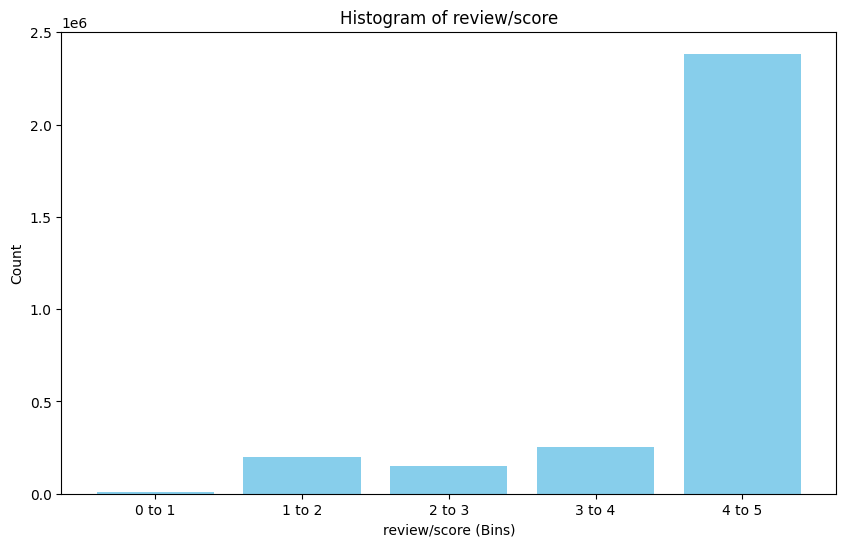

In [16]:
import matplotlib.pyplot as plt

# Define the bins and their counts
bins = ["0 to 1", "1 to 2", "2 to 3", "3 to 4", "4 to 5"]
counts = [8820, 201571, 151599, 254377, 2383633]

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.bar(bins, counts, color="skyblue")
plt.xlabel("review/score (Bins)")
plt.ylabel("Count")
plt.title("Histogram of review/score")
plt.show()

# Normalizing review/helpfulness column
1. Will leverage the normalize_string_to_float_udf to transform all strings to value scaled between 0 and 5
2. Rest of the values will be padded with 0

In [17]:
books_rating_df = books_rating_df.withColumn("review/helpfulness", normalize_string_to_float_udf(books_rating_df["review/helpfulness"]))
books_rating_df.select(col('review/helpfulness')).show()
books_rating_df.printSchema()
null_counts_books_review_score = books_rating_df.select(count(when(col('review/helpfulness').isNull(), 'review/helpfulness')).alias('Num of Null values in review/helpfulness column'))
null_counts_books_review_score.show()
hist_data = books_rating_df.select("review/helpfulness").rdd.flatMap(lambda x: x).histogram([0, 1, 2, 3, 4, 5])

# Display bin counts
review_helpfulness_bin_ranges = hist_data[0]
review_helpfulness_counts = hist_data[1]

# Show results in tabular form
for i in range(len(counts)):
    print(f"Bin {review_helpfulness_bin_ranges[i]} to {review_helpfulness_bin_ranges[i+1]}: Count = {review_helpfulness_counts[i]}")


+------------------+
|review/helpfulness|
+------------------+
|               5.0|
|               5.0|
|         4.5454545|
|               5.0|
|               5.0|
|               5.0|
|              3.75|
|               0.0|
|               0.0|
|               3.0|
|               4.0|
|               5.0|
|               5.0|
|               5.0|
|         3.1818182|
|               2.5|
|               2.5|
|               2.5|
|         2.7777777|
|         1.6666666|
+------------------+
only showing top 20 rows

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: float (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

+-----------------------------------------------+


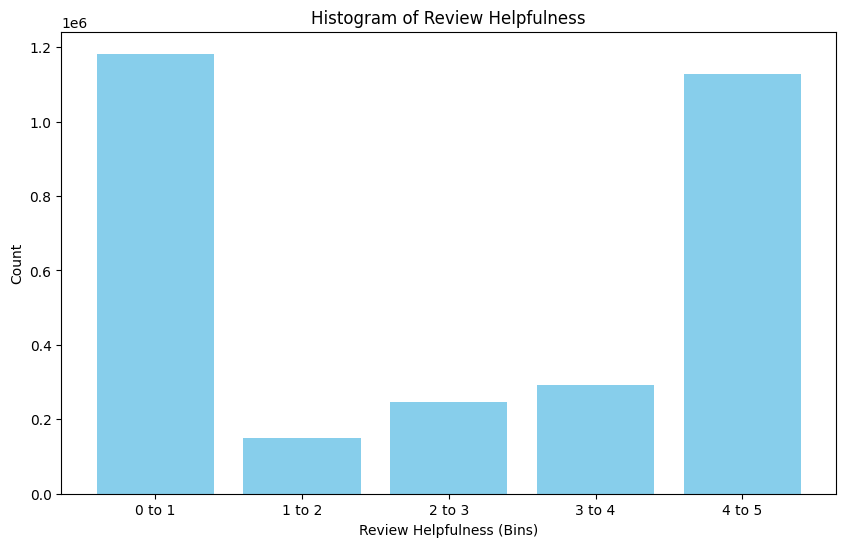

In [24]:
import matplotlib.pyplot as plt

# Define the bins and their counts
bins = ["0 to 1", "1 to 2", "2 to 3", "3 to 4", "4 to 5"]
counts = [1182589, 149972, 247809, 291851, 1127779]

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.bar(bins, counts, color="skyblue")
plt.xlabel("Review Helpfulness (Bins)")
plt.ylabel("Count")
plt.title("Histogram of Review Helpfulness")
plt.show()

# Checking null values for every column after normalization

In [18]:
null_counts_books_rating = books_rating_df.select([count(when(col(c).isNull(), c)).alias(c) for c in books_rating_df.columns]).collect()[0].asDict()
print("\nNull counts for books_rating_df:")
for col_name, null_count in null_counts_books_rating.items():
    print(f"{col_name} : {null_count}")


Null counts for books_rating_df:
Id : 0
Title : 208
Price : 2517579
User_id : 562250
profileName : 562200
review/helpfulness : 0
review/score : 0
review/time : 27
review/summary : 65
review/text : 43


In [30]:
from pyspark.sql.functions import array_contains

# Filter rows where the categories array contains 'Fiction'
fiction_books_df = books_data_df.filter(array_contains(books_data_df.categories, "Fiction"))

# Select the publisher column
publishers_fiction_df = fiction_books_df.select("authors")

# Show the result
publishers_fiction_df.show()

+--------------------+
|             authors|
+--------------------+
| ['Veronica Haddon']|
|['Elizabeth Sincl...|
| ['Cara Delevingne']|
| ['Kevin Valgaeren']|
|     ['Alan Nourse']|
| ['Anthony Capella']|
| ['Thomas Chastain']|
|    ['Timothy Zahn']|
|['Patricia Cornwe...|
|['Patricia Cornwe...|
|  ['Candi Adermatt']|
|['Frederik Pohl',...|
|    ['Rick Hautala']|
|  ['Sharon De Vita']|
|    ['Jack Higgins']|
|  ['Alanna Morland']|
| ['Robert F. Jones']|
|      ['Tanith Lee']|
|['Juliet Marillier']|
|['Philip José Far...|
+--------------------+
only showing top 20 rows



+--------------------+------------------+------------+------------------+
|               Title|       total_score|review_count|     average_score|
+--------------------+------------------+------------+------------------+
|   The animal family|             240.0|          48|               5.0|
|Christ's Object L...|             205.0|          41|               5.0|
|Lilla Belle: The ...|             565.0|         113|               5.0|
|A Reason To Live ...|             225.0|          45|               5.0|
|The Road to Guada...|             225.0|          45|               5.0|
|The song of Hiawatha|             225.0|          45|               5.0|
|      The ice people|             230.0|          46|               5.0|
|There Are Survivo...|             334.0|          67| 4.985074626865671|
|Back to Basics: H...|253.88924074172974|          51| 4.978220406700583|
|Death in Slow Mot...|             214.0|          43| 4.976744186046512|
|Forbidden Game, C...|             403

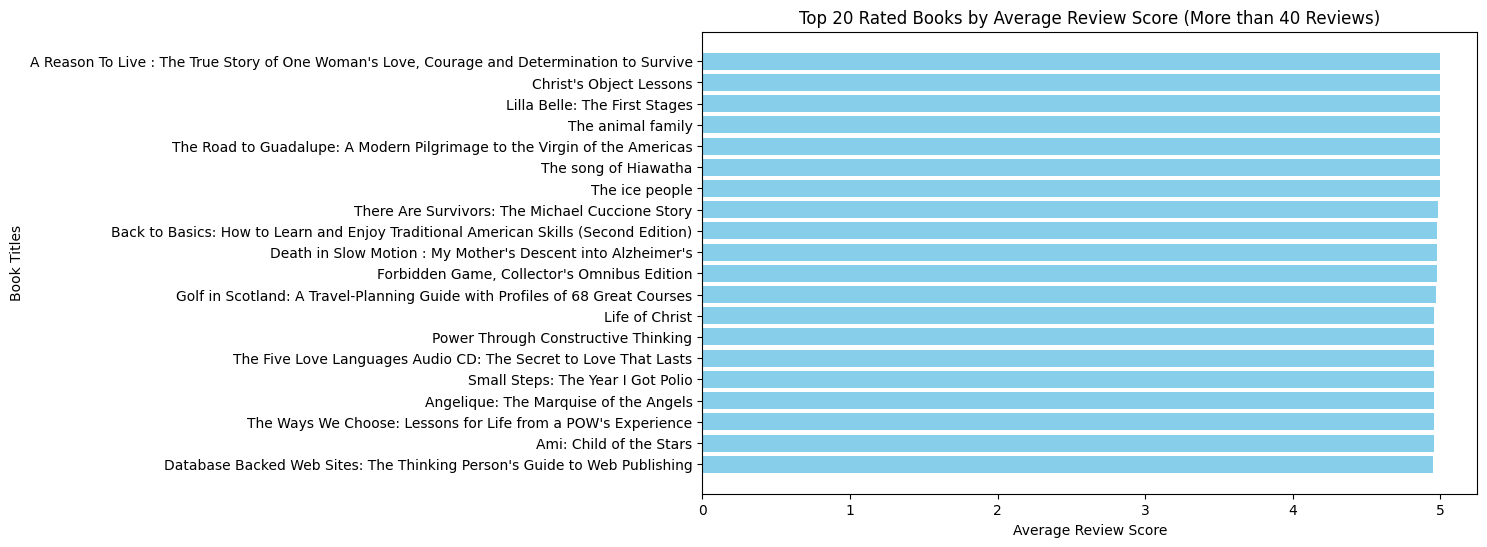

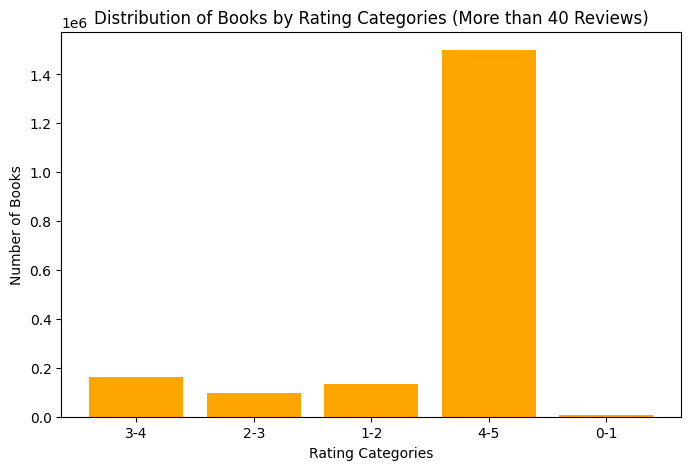

In [46]:
## Top Rated Books: Average review/score per Title

from pyspark.sql import functions as F



# Step 1: Calculate Average Review Score per Title
average_scores = books_rating_df.groupBy("Title").agg(
    F.sum(F.col("review/score").cast("double")).alias("total_score"),
    F.count("review/score").alias("review_count")
).withColumn("average_score", F.col("total_score") / F.col("review_count"))

# Step 1.1: Filter books with more than 40 reviews
filtered_scores = average_scores.filter(F.col("review_count") > 40)

# Show top-rated books (titles with highest average scores)
top_rated_books = filtered_scores.orderBy(F.desc("average_score"))
top_rated_books.show()

# Step 2: Categorize Books by Review Scores
filtered_books = books_rating_df.join(filtered_scores, "Title", "inner")

rating_categories = filtered_books.withColumn(
    "rating_category",
    F.when(F.col("review/score").cast("double") < 1, "0-1")
    .when((F.col("review/score").cast("double") >= 1) & (F.col("review/score").cast("double") < 2), "1-2")
    .when((F.col("review/score").cast("double") >= 2) & (F.col("review/score").cast("double") < 3), "2-3")
    .when((F.col("review/score").cast("double") >= 3) & (F.col("review/score").cast("double") < 4), "3-4")
    .when((F.col("review/score").cast("double") >= 4), "4-5")
)

category_counts = rating_categories.groupBy("rating_category").count()

# Convert category counts to an RDD for plotting
category_counts_rdd = category_counts.rdd.map(lambda row: (row["rating_category"], row["count"]))

# Step 3: Visualization
# Plot Top Rated Books (Average Review Scores)
import matplotlib.pyplot as plt

top_40_books = top_rated_books.limit(40)
output_path = "top_40_books.csv"
top_40_books.write.option("header", True).csv(output_path)


top_books_rdd = top_rated_books.limit(20).rdd.map(lambda row: (row["Title"], row["average_score"]))
titles, scores = zip(*top_books_rdd.collect())

plt.figure(figsize=(10, 6))
plt.barh(titles, scores, color="skyblue")



plt.xlabel("Average Review Score")
plt.ylabel("Book Titles")
plt.title("Top 20 Rated Books by Average Review Score (More than 40 Reviews)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.savefig("averageReviewScore.png")
plt.show()

# Plot Rating Categories Distribution
categories, counts = zip(*category_counts_rdd.collect())

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color="orange")
plt.xlabel("Rating Categories")
plt.ylabel("Number of Books")
plt.title("Distribution of Books by Rating Categories (More than 40 Reviews)")
plt.savefig("bookDistribution.png")
plt.show()

Correlation between Price and review_score: -0.0094694461514835


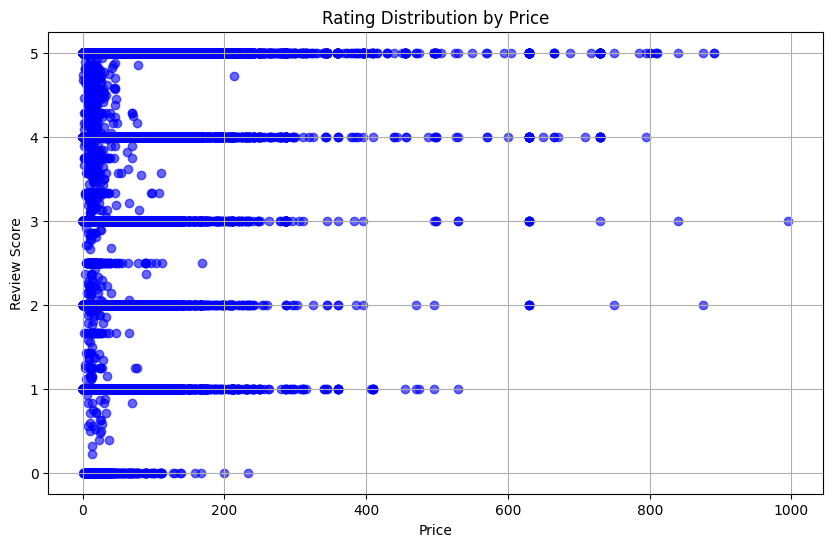

In [49]:
##### Rating Distribution by Price: Correlation between Price and review/score
joined_df = books_rating_df.join(books_data_df, on="Title", how="inner")

# Convert Price and review/score to float
numeric_df = joined_df.withColumn("Price", F.col("Price").cast("float")) \
                      .withColumn("review_score", F.col("review/score").cast("float"))

# Filter out rows with null or invalid Price and review_score
numeric_df = numeric_df.filter(F.col("Price").isNotNull() & F.col("review_score").isNotNull())
numeric_df = numeric_df.withColumn("categories", F.concat_ws(",", F.col("categories")))

top40 = numeric_df.limit(40)
output_path = "price_ratings.csv"
top40.write.option("header", True).csv(output_path)


# Compute correlation between Price and review_score
correlation = numeric_df.stat.corr("Price", "review_score")
print(f"Correlation between Price and review_score: {correlation}")

# Extract data for scatter plot
scatter_data = numeric_df.select("Price", "review_score").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scatter_data["Price"], scatter_data["review_score"], alpha=0.6, color='blue')
plt.title("Rating Distribution by Price")
plt.xlabel("Price")
plt.ylabel("Review Score")
plt.grid(True)
plt.savefig("priceRatings.png")
plt.show()

In [ ]:
from pyspark.sql.types import DoubleType

# Convert Price and review/score to numeric
books_rating_df = books_rating_df.withColumn("Price", col("Price").cast(DoubleType())) \
    .withColumn("review_score", col("review/score").cast(DoubleType()))

# Filter out rows with null or invalid Price and review/score
books_rating_df = books_rating_df.filter(col("Price").isNotNull() & col("review_score").isNotNull())

# 1. Rating Distribution by Price (Group by Price Range)
price_distribution = books_rating_df \
    .withColumn("PriceRange", when(col("Price") < 10, "<$10")
                .when((col("Price") >= 10) & (col("Price") < 20), "$10-$20")
                .when((col("Price") >= 20) & (col("Price") < 50), "$20-$50")
                .otherwise(">$50")) \
    .groupBy("PriceRange") \
    .agg(avg("review_score").alias("AverageReviewScore")) \
    .orderBy("PriceRange")

price_distribution.show()

# 2. Correlation between Price and review/score
correlation = books_rating_df.stat.corr("Price", "review_score")
print(f"Correlation between Price and review/score: {correlation}")

+----------+------------------+
|PriceRange|AverageReviewScore|
+----------+------------------+
|   $10-$20| 4.270172909359008|
|   $20-$50| 4.183837460989402|
|      <$10|4.1106677437436465|
|      >$50|   4.1592180828866|
+----------+------------------+

Correlation between Price and review/score: -0.009467361053547821


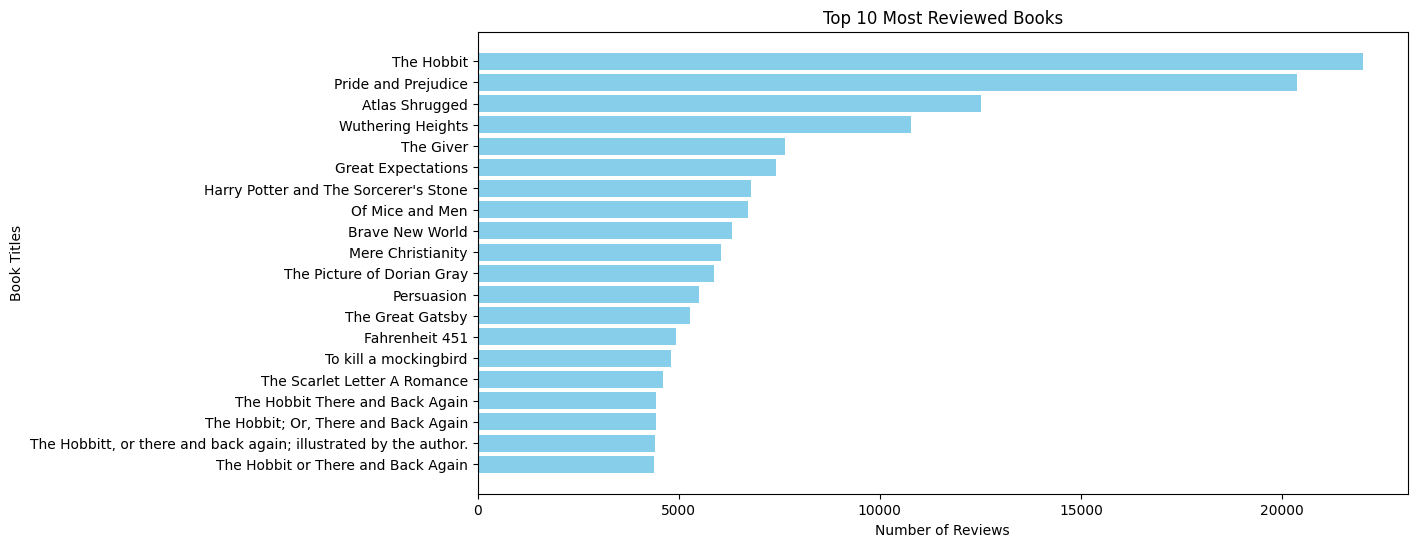

In [50]:
#### Most Reviewed Books: Number of reviews per Title
most_reviewed_books = books_rating_df.groupBy("Title") \
    .count() \
    .withColumnRenamed("count", "NumberOfReviews") \
    .orderBy(col("NumberOfReviews").desc())

top_reviewed_books = most_reviewed_books.limit(20).collect()

top_reviewed_books_40 = most_reviewed_books.limit(40)
top_reviewed_books_40.write.csv("top_reviewed_books.csv", header=True, mode="overwrite")


titles = [row['Title'] for row in top_reviewed_books]
review_counts = [row['NumberOfReviews'] for row in top_reviewed_books]

plt.figure(figsize=(12, 6))
plt.barh(titles, review_counts, color='skyblue')
plt.xlabel('Number of Reviews')
plt.ylabel('Book Titles')
plt.title('Top 10 Most Reviewed Books')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest value at the top
plt.savefig("topReviewed.png")
plt.show()

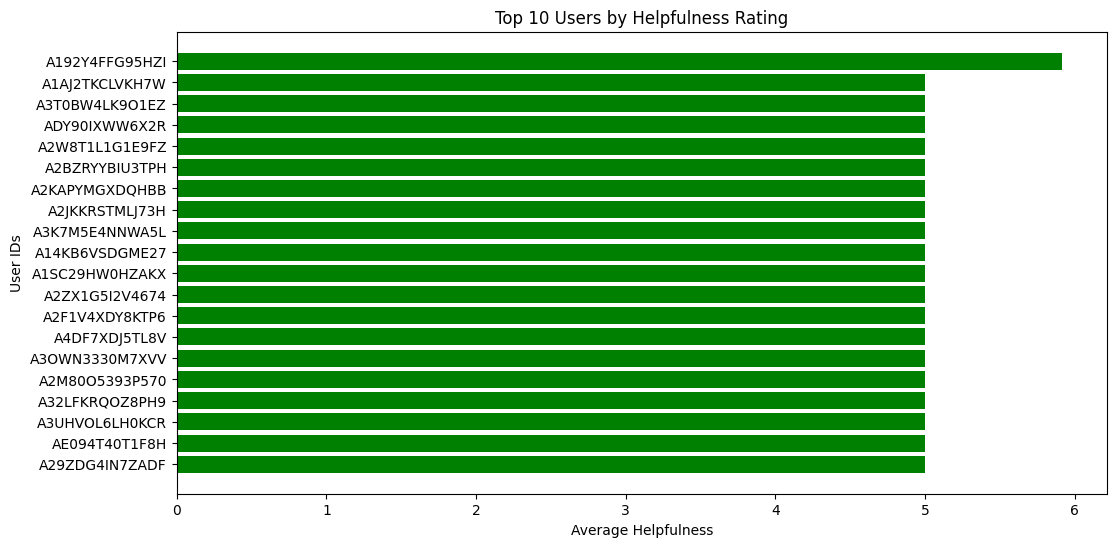

In [51]:
##### Helpfulness Rating Distribution: Average review/helpfulness per user_Id

helpfulness_temp_df = books_rating_df.withColumn(
    "review/helpfulness",
    col("review/helpfulness").cast("double")
)

helpfulness_avg = helpfulness_temp_df.groupBy("User_id") \
    .agg(avg("review/helpfulness").alias("AverageHelpfulness")) \
    .orderBy(col("AverageHelpfulness").desc())

top_helpfulness_users = helpfulness_avg.limit(20).collect()

top_helpfulness_users40 = helpfulness_avg.limit(40)
top_helpfulness_users40.write.csv("top_helpfulness_users.csv", header=True, mode="overwrite")


user_ids = [row["User_id"] for row in top_helpfulness_users]
avg_helpfulness = [row["AverageHelpfulness"] for row in top_helpfulness_users]

plt.figure(figsize=(12, 6))
plt.barh(user_ids, avg_helpfulness, color='green')
plt.xlabel('Average Helpfulness')
plt.ylabel('User IDs')
plt.title('Top 10 Users by Helpfulness Rating')
plt.gca().invert_yaxis()  # Display highest value at the top
plt.savefig("topReviewers.png")
plt.show()

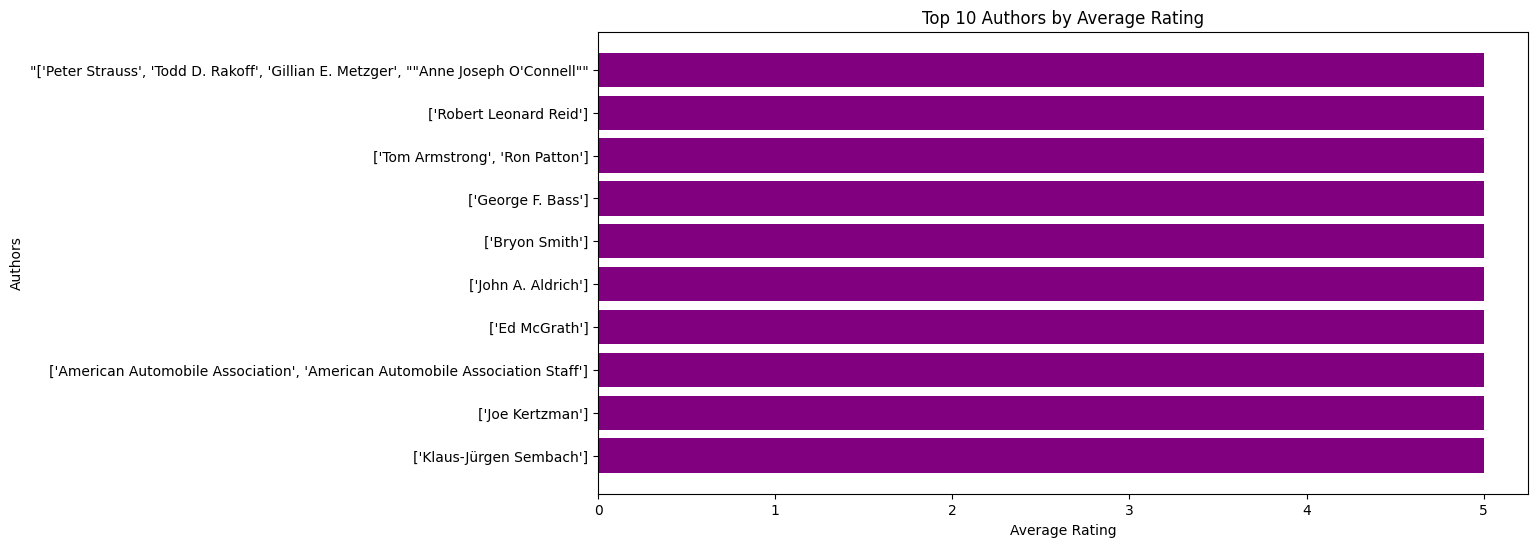

In [52]:
### Top 10 Authors by Average Rating

joined_df = books_data_df.join(books_rating_df, on="Title", how="inner")

joined_df = joined_df.withColumn("review/score", col("review/score").cast("double"))

authors_avg = joined_df.groupBy("authors") \
    .agg(avg("review/score").alias("AverageRating")) \
    .orderBy(col("AverageRating").desc())

top_authors = authors_avg.limit(10).collect()

top_authors_40 = authors_avg.limit(40)
top_authors_40.write.csv("top_authors.csv", header=True, mode="overwrite")

author_names = [row["authors"] for row in top_authors]
avg_ratings = [row["AverageRating"] for row in top_authors]

plt.figure(figsize=(12, 6))
plt.barh(author_names, avg_ratings, color='purple')
plt.xlabel('Average Rating')
plt.ylabel('Authors')
plt.title('Top 10 Authors by Average Rating')
plt.gca().invert_yaxis()  # Display highest value at the top
plt.savefig("top_authors.png")
plt.show()

<ipython-input-53-7aee1ad1aa0a>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(categories, rotation=45, ha="right")


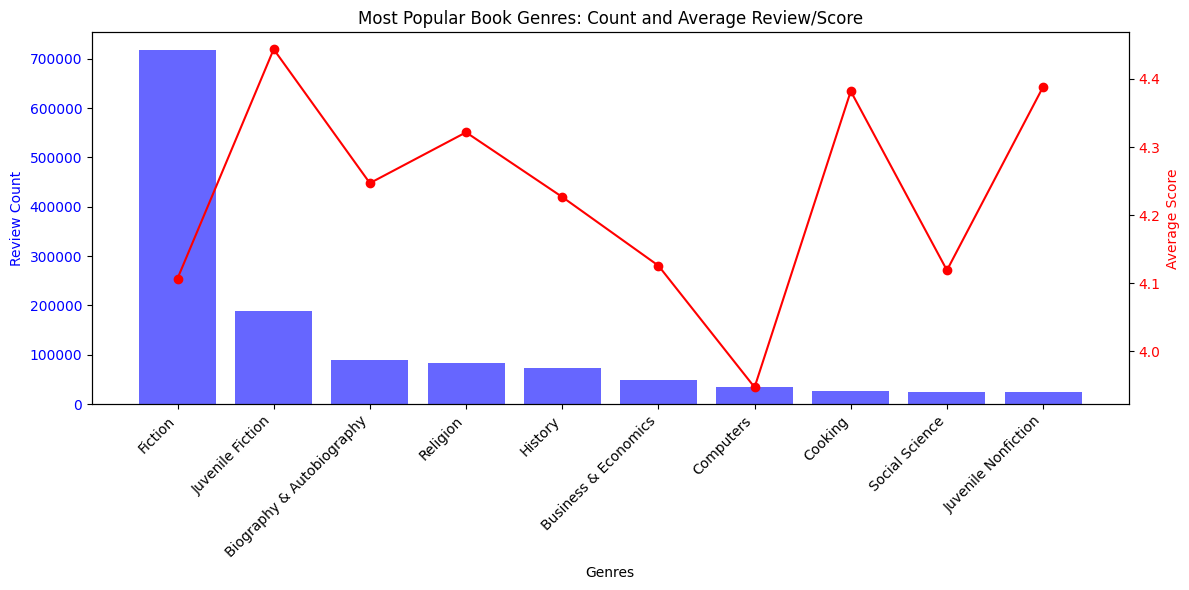

In [53]:
#### Most Popular Book Genres: Count and average review/score per categories.

exploded_df = books_data_df.withColumn("category", explode(col("categories")))

joined_df = exploded_df.join(books_rating_df, on="Title", how="inner")

joined_df = joined_df.withColumn("review/score", col("review/score").cast("double"))

genres_stats = joined_df.groupBy("category") \
    .agg(
        count("review/score").alias("ReviewCount"),
        avg("review/score").alias("AverageScore")
    ) \
    .orderBy(col("ReviewCount").desc())



genres_data = genres_stats.limit(10).collect()


genres_data_40 = genres_stats.limit(40)
genres_data_40.write.csv("genres_data.csv", header=True, mode="overwrite")

categories = [row["category"] for row in genres_data]
review_counts = [row["ReviewCount"] for row in genres_data]
average_scores = [row["AverageScore"] for row in genres_data]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(categories, review_counts, color='blue', alpha=0.6, label="Review Count")
ax1.set_xlabel('Genres')
ax1.set_ylabel('Review Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(categories, rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(categories, average_scores, color='red', marker='o', label="Average Score")
ax2.set_ylabel('Average Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Most Popular Book Genres: Count and Average Review/Score')

plt.savefig("topGenres.png")

fig.tight_layout()
plt.show()

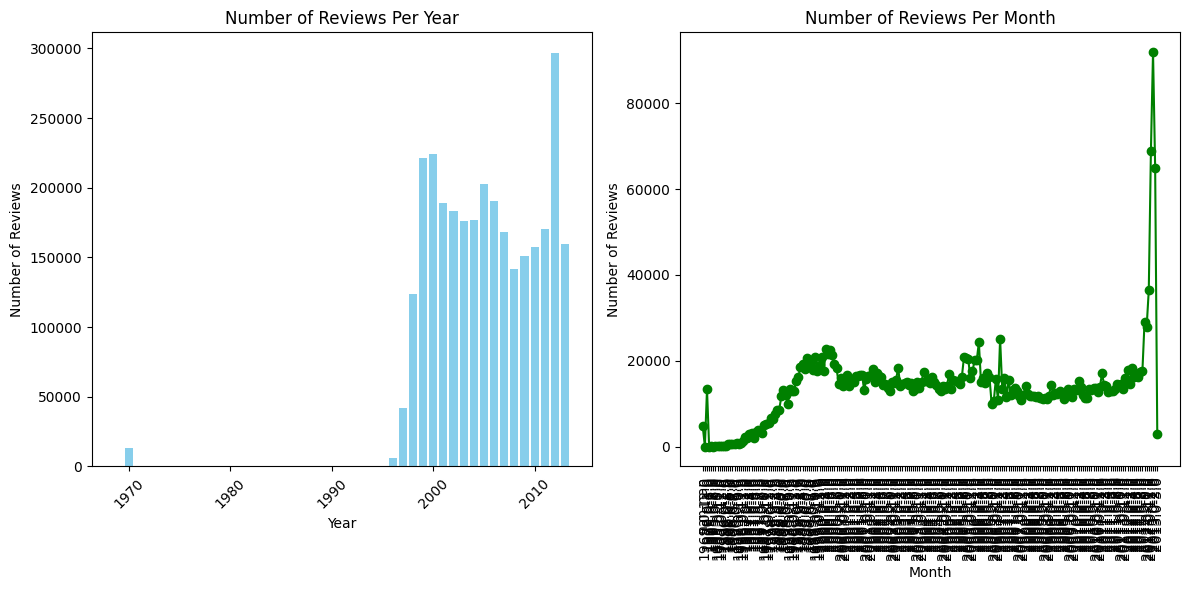

In [55]:
####### Review Time Analysis: Number of reviews per time period (e.g., year/month)

from pyspark.sql.functions import col, from_unixtime, year, month, count

books_rating_df = books_rating_df.withColumn("review_date", from_unixtime(col("review/time")))

books_rating_df = books_rating_df.withColumn("review_year", year(col("review_date"))) \
                                 .withColumn("review_month", month(col("review_date")))

yearly_reviews = books_rating_df.groupBy("review_year").agg(count("*").alias("review_count")).orderBy("review_year")
monthly_reviews = books_rating_df.groupBy("review_year", "review_month").agg(count("*").alias("review_count")).orderBy("review_year", "review_month")

yearly = yearly_reviews.limit(40)
yearly.write.csv("yearlyReviews.csv", header=True, mode="overwrite")

monthly = monthly_reviews.limit(40)
monthly.write.csv("monthlyReviews.csv", header=True, mode="overwrite")

yearly_data = yearly_reviews.toPandas()
monthly_data = monthly_reviews.toPandas()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(yearly_data["review_year"], yearly_data["review_count"], color='skyblue')
plt.title("Number of Reviews Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
monthly_data['YearMonth'] = monthly_data['review_year'].astype(str) + '-' + monthly_data['review_month'].astype(str)
plt.plot(monthly_data['YearMonth'], monthly_data['review_count'], marker='o', color='green')
plt.title("Number of Reviews Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig("reviewtime.png")
plt.show()

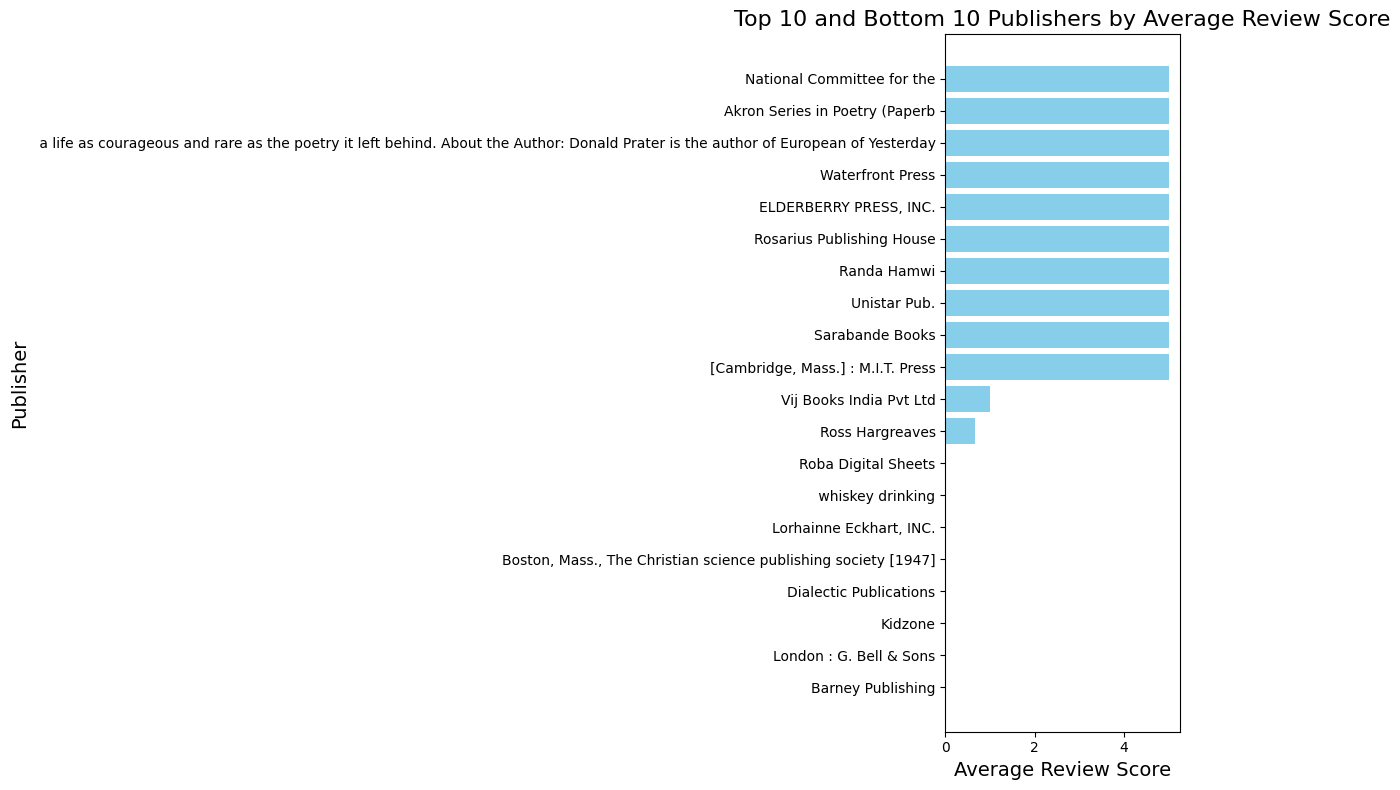

In [56]:
########## Rating Distribution by Publisher: Average review/score per publisher

import matplotlib.pyplot as plt

# Step 1: Calculate average review score per publisher
average_score_df = (
    joined_df
    .withColumn("review_score", col("review/score").cast("float"))  # Convert to float
    .filter(col("review_score").isNotNull())                       # Filter out null review scores
    .filter(col("publisher").isNotNull())                          # Filter out null publishers
    .groupBy("publisher")
    .agg(avg("review_score").alias("average_review_score"))         # Calculate average
)

# Step 2: Get top 10 and bottom 10 publishers

publisherRating_40 = average_score_df.limit(40)
publisherRating_40.write.csv("publisherRating.csv", header=True, mode="overwrite")

top_10_df = average_score_df.orderBy(col("average_review_score").desc()).limit(10)
bottom_10_df = average_score_df.orderBy(col("average_review_score").asc()).limit(10)

# Combine the two subsets
top_and_bottom_df = top_10_df.union(bottom_10_df)

# Step 3: Collect the data into Python for visualization
data = top_and_bottom_df.collect()

# Step 4: Extract publishers and scores for visualization
publishers = [row['publisher'] for row in data]
scores = [row['average_review_score'] for row in data]

# Step 5: Sort data for better visualization
sorted_data = sorted(zip(scores, publishers), key=lambda x: x[0])
scores, publishers = zip(*sorted_data)

# Step 6: Visualize the data using Matplotlib
plt.figure(figsize=(12, 8))
plt.barh(publishers, scores, color='skyblue')

# Add labels and title
plt.xlabel("Average Review Score", fontsize=14)
plt.ylabel("Publisher", fontsize=14)
plt.title("Top 10 and Bottom 10 Publishers by Average Review Score", fontsize=16)

# Show the plot
plt.tight_layout()
plt.savefig("publisherRatings.png")

plt.show()

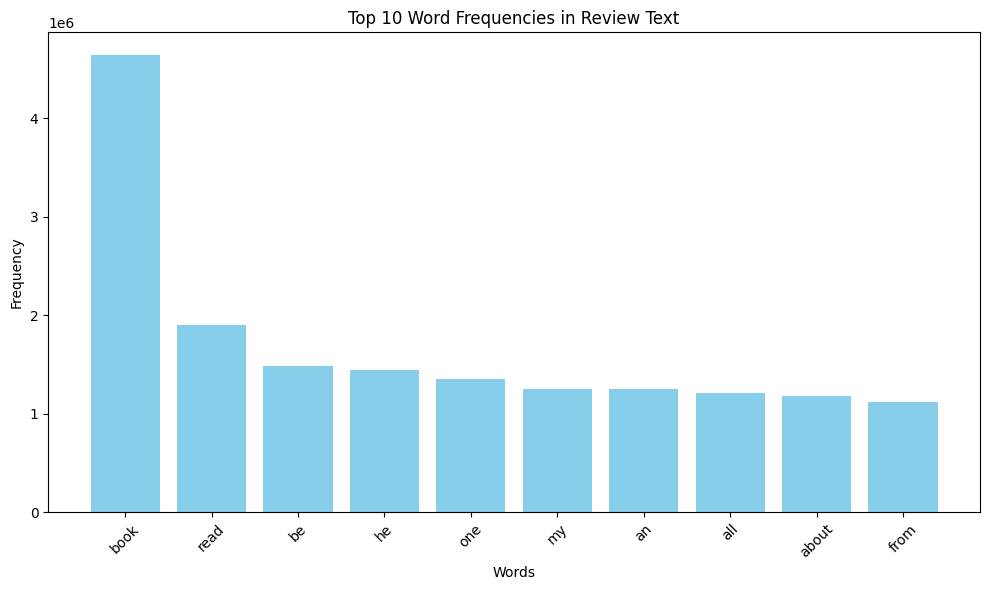

In [ ]:
####### Word Frequency Analysis of Review Text: Frequency of the top 10 words in review/text.

from pyspark.sql.functions import col, explode, lower, regexp_replace, split
from collections import Counter
import matplotlib.pyplot as plt

# Step 1: Preprocess review text (convert to lowercase and remove punctuation)
books_rating_df = books_rating_df.withColumn("clean_text",
    lower(regexp_replace(col("review/text"), "[^a-zA-Z\\s]", "")))

# Step 2: Tokenize the text (split into words)
books_rating_df = books_rating_df.withColumn("words", split(col("clean_text"), "\\s+"))

# Step 3: Explode the words into individual rows
words_df = books_rating_df.select(explode(col("words")).alias("word"))

# Step 4: Remove stopwords
stopwords = [
    "a", "an", "the", "he", "she", "it", "they", "we", "I", "you", "them", "us", "me",
    "and", "but", "if", "or", "nor", "for", "so", "yet",
    "in", "on", "at", "for", "to", "from", "of", "about", "with", "by", "as", "into",
    "during", "between",
    "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having",
    "do", "does", "did", "doing",
    "can", "could", "will", "would", "shall", "should", "may", "might", "must",
    "this", "that", "these", "those", "my", "your", "his", "her", "its", "our", "their",
    "who", "what", "where", "when", "why", "how",
    "all", "some", "any", "much", "many", "few", "several",
    "not", "only", "own", "same", "very", "just", "here", "there", "how", "too", "more", "less", "then", "now"
]
filtered_words_df = words_df.filter(~col("word").isin(stopwords) & (col("word") != ""))

# Step 5: Count word occurrences
word_counts = filtered_words_df.groupBy("word").count().orderBy(col("count").desc())


word_counts_40 = word_counts.limit(40)
word_counts_40.write.csv("word_counts.csv", header=True, mode="overwrite")


# Step 6: Collect top 10 words for visualization
top_words = word_counts.limit(10).toPandas()

# Step 7: Plot the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(top_words["word"], top_words["count"], color="skyblue")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 10 Word Frequencies in Review Text")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

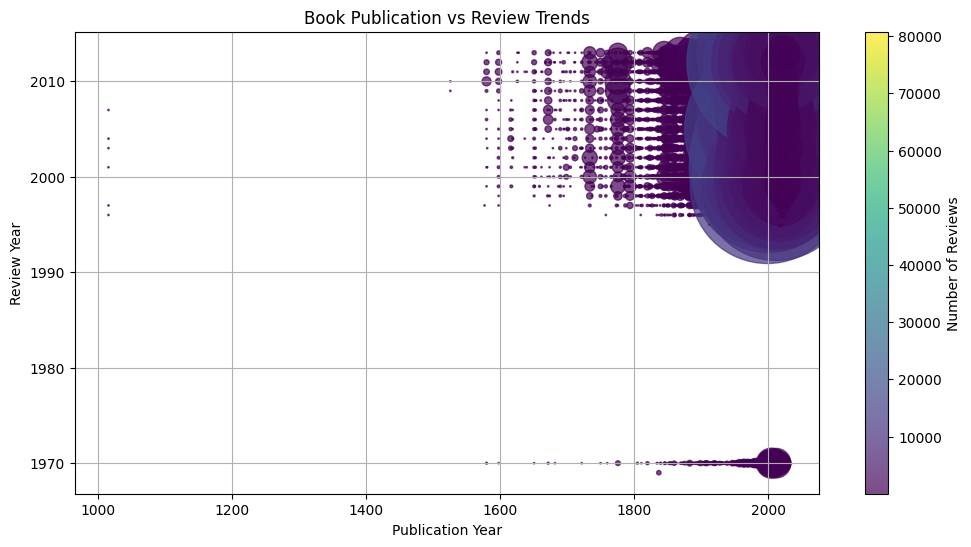

In [57]:
### time series analysis based on publishing date and review date


from pyspark.sql import functions as F
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt

books_data_df = books_data_df.withColumn(
    "publishedDate_clean",
    F.when(F.length("publishedDate") == 4, F.concat(F.col("publishedDate"), F.lit("-01-01")))
     .when(F.length("publishedDate") == 7, F.concat(F.col("publishedDate"), F.lit("-01")))
     .otherwise(F.col("publishedDate"))
).withColumn("publishedDate_clean", F.to_date("publishedDate_clean", "yyyy-MM-dd"))

# Fix review/time normalization
books_rating_df = books_rating_df.withColumn(
    "review_time_clean", F.from_unixtime(F.col("review/time").cast("long"), "yyyy-MM-dd")
)
# Step 3: Join the DataFrames
joined_df = books_data_df.join(
    books_rating_df, on="Title", how="inner"
).select("Title", "publishedDate_clean", "review_time_clean")

# Step 4: Group and Aggregate Data
review_trends = joined_df.groupBy(
    F.year("publishedDate_clean").alias("published_year"),
    F.year("review_time_clean").alias("review_year")
).count().orderBy("published_year", "review_year")


review_trends.write.csv("review_trends.csv", header=True, mode="overwrite")


# Step 5: Collect Data for Visualization
trends_data = review_trends.collect()

# Prepare data for plotting
published_years = [row["published_year"] for row in trends_data]
review_years = [row["review_year"] for row in trends_data]
counts = [row["count"] for row in trends_data]

# Step 6: Plot using Matplotlib
plt.figure(figsize=(12, 6))
plt.scatter(published_years, review_years, c=counts, cmap="viridis", s=counts, alpha=0.7)
plt.colorbar(label="Number of Reviews")
plt.title("Book Publication vs Review Trends")
plt.xlabel("Publication Year")
plt.ylabel("Review Year")
plt.grid(True)
plt.savefig("trends.png")
plt.show()

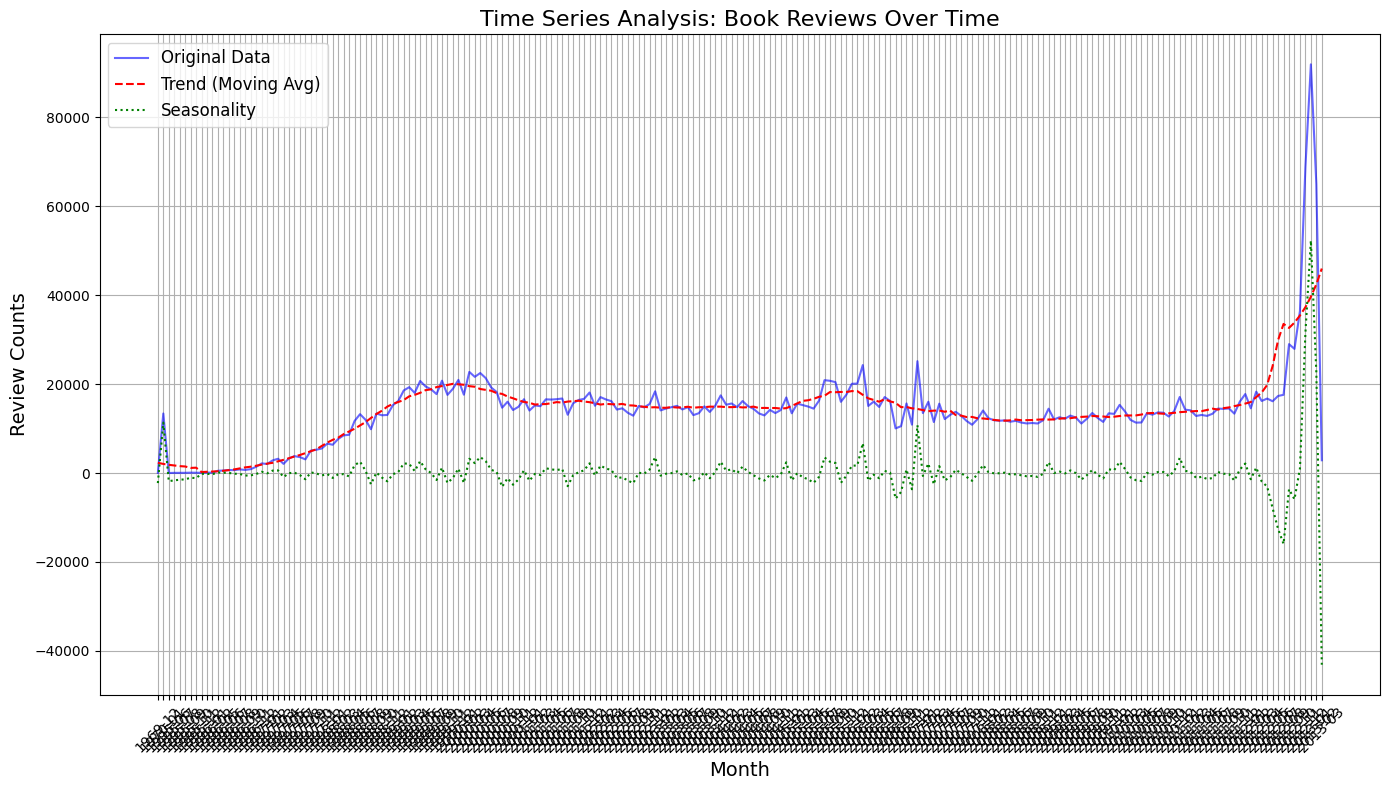

In [59]:
from pyspark.sql.window import Window

# Step 1: Normalize `publishedDate` and `review_time`
books_data_df = books_data_df.withColumn(
    "publishedDate_clean",
    F.when(F.length("publishedDate") == 4, F.concat(F.col("publishedDate"), F.lit("-01-01")))
     .when(F.length("publishedDate") == 7, F.concat(F.col("publishedDate"), F.lit("-01")))
     .otherwise(F.col("publishedDate"))
).withColumn("publishedDate_clean", F.to_date("publishedDate_clean", "yyyy-MM-dd"))

books_rating_df = books_rating_df.withColumn(
    "review_time_clean", F.from_unixtime(F.col("review/time").cast("long"), "yyyy-MM-dd")
)

# Step 2: Join and Aggregate Reviews by Month
joined_df = books_data_df.join(
    books_rating_df, on="Title", how="inner"
).select("publishedDate_clean", "review_time_clean")

monthly_reviews = joined_df.withColumn(
    "review_month", F.date_trunc("month", "review_time_clean")
).groupBy("review_month").count().orderBy("review_month")

# Step 3: Calculate Moving Averages for Trend and Seasonality
window_spec = Window.orderBy("review_month").rowsBetween(-6, 6)  # 6-month rolling window
trend_df = monthly_reviews.withColumn(
    "moving_avg", F.avg("count").over(window_spec)
)

# Step 4: Extract Seasonality
seasonality_df = trend_df.withColumn(
    "seasonality", F.col("count") - F.col("moving_avg")
)

# Step 5: Collect Data for Visualization
time_series_data = seasonality_df.select("review_month", "count", "moving_avg", "seasonality").filter("review_month IS NOT NULL").collect()



# Prepare data for plotting
months = [
    row["review_month"].strftime("%Y-%m") if row["review_month"] is not None else "Unknown"
    for row in time_series_data
]
counts = [row["count"] for row in time_series_data]
trends = [row["moving_avg"] for row in time_series_data]
seasonality = [row["seasonality"] for row in time_series_data]

# Plot the Time Series
plt.figure(figsize=(14, 8))

# Plot original data
plt.plot(months, counts, label="Original Data", color="blue", alpha=0.6)

# Plot trend
plt.plot(months, trends, label="Trend (Moving Avg)", color="red", linestyle="--")

# Plot seasonality
plt.plot(months, seasonality, label="Seasonality", color="green", linestyle=":")

# Add labels and legend
plt.title("Time Series Analysis: Book Reviews Over Time", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Review Counts", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc="upper left", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("seasonality.png")
plt.show()

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
pip install pyngrok

In [ ]:
from pyngrok import ngrok

# Start Streamlit server
!streamlit run dashboards.py &

# Expose the Streamlit app to the internet
url = ngrok.connect(port=8501)
print(f"Streamlit app is live at: {url}")




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.231.35.74:8501

  Stopping...


ERROR:pyngrok.process.ngrok:t=2024-12-05T14:36:34+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-12-05T14:36:34+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-12-05T14:36:34+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [61]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, year
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import concat_ws

# Data Preprocessing
# Join the data on Title
combined_df = books_data_df.join(books_rating_df, on="Title", how="inner")

# Calculate average review score
combined_df = combined_df.withColumn("review_score", col("review/score").cast("float")) \
                         .withColumn("ratingsCount", col("ratingsCount").cast("float")) \
                         .withColumn("Price", col("Price").cast("float")) \
                         .withColumn("avg_review_score", col("review_score") / col("ratingsCount"))
combined_df = combined_df.withColumn("categories", concat_ws(", ", col("categories")))
# Handle missing values
combined_df = combined_df.na.drop(subset=["authors", "categories", "publisher", "Price", "avg_review_score"])

# List of categorical columns to check
categorical_columns = ["authors", "categories", "publisher"]

# Drop rows where any of these columns are null or empty
combined_df = combined_df.filter(
    " AND ".join([f"{col_name} IS NOT NULL AND {col_name} != ''" for col_name in categorical_columns])
)
combined_df = combined_df.withColumn("publishedYear", year(col("publishedDate").cast("timestamp")))

# Select relevant features
feature_columns = ["authors", "categories", "publisher", "publishedYear", "Price", "avg_review_score"]
combined_df = combined_df.select(*feature_columns)

# Split the data into two sets for the two prediction tasks
# 1. Predicting price range for max avg review score
price_features = ["authors", "categories", "publisher", "publishedYear"]
price_df = combined_df.select(*price_features, "Price", "avg_review_score")

# 2. Predicting avg review score for given price
score_features = ["authors", "categories", "publisher", "publishedYear", "Price"]
score_df = combined_df.select(*score_features, "avg_review_score")

# Prepare pipelines for categorical encoding and feature assembly
# Define feature processing pipeline
def prepare_pipeline(input_features, label_col):
    stages = []

    # Index and encode categorical features
    for feature in ["authors", "categories", "publisher"]:
        indexer = StringIndexer(inputCol=feature, outputCol=f"{feature}_index")
        encoder = OneHotEncoder(inputCol=f"{feature}_index", outputCol=f"{feature}_encoded")
        stages += [indexer, encoder]

    # Assemble all features
    assembled_features = [f"{feature}_encoded" for feature in ["authors", "categories", "publisher"]] + \
                         [col for col in input_features if col not in ["authors", "categories", "publisher"]]
    assembler = VectorAssembler(inputCols=assembled_features, outputCol="features", handleInvalid="skip")
    stages.append(assembler)

    return Pipeline(stages=stages)

# 1. Predicting Price Range
price_pipeline = prepare_pipeline(price_features, "Price")
price_prepared = price_pipeline.fit(price_df).transform(price_df)

# 2. Predicting Avg Review Score
score_pipeline = prepare_pipeline(score_features, "avg_review_score")


# Split data into train and test sets
price_train, price_test = price_prepared.randomSplit([0.8, 0.2], seed=42)
#score_train, score_test = score_prepared.randomSplit([0.8, 0.2], seed=42)

# Model Training
# Random Forest Regressor for both tasks
price_model = RandomForestRegressor(featuresCol="features", labelCol="Price")
#score_model = RandomForestRegressor(featuresCol="features", labelCol="avg_review_score")

# Train models
price_model_fitted = price_model.fit(price_train)
#score_model_fitted = score_model.fit(score_train)

# Model Evaluation
# Evaluate Price Model
price_predictions = price_model_fitted.transform(price_test)
price_evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
price_rmse = price_evaluator.evaluate(price_predictions)
print(f"Price Prediction RMSE: {price_rmse}")

# Evaluate Score Model
#score_predictions = score_model_fitted.transform(score_test)
#score_evaluator = RegressionEvaluator(labelCol="avg_review_score", predictionCol="prediction", metricName="rmse")
#score_rmse = score_evaluator.evaluate(score_predictions)
#print(f"Review Score Prediction RMSE: {score_rmse}")



Price Prediction RMSE: 16.349837325640845


In [42]:
fiction_books_df = combined_df.filter(col("authors").contains("['Mary Ray']"))

# Select distinct authors
distinct_authors_fiction_df = fiction_books_df.select("price").distinct()

# Show the result
distinct_authors_fiction_df.show()

+-----+
|price|
+-----+
|11.11|
+-----+



In [41]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
schema = StructType([
    StructField("authors", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("publisher", StringType(), True),
    StructField("publishedYear", IntegerType(), True),
    StructField("Price", DoubleType(), True)  # Set to DoubleType to allow null (None) values
])

# Prediction for New Books
# Example: Predict price range for a new book
new_book = spark.createDataFrame([{
    "authors": "['Mary Ray']",
    "categories": "Fiction",
    "publisher": "Capstone",
    "publishedYear": 2024,
    "Price": None  # Price is not known for price prediction
}], schema=schema)

new_book_price_prepared = price_pipeline.fit(price_df).transform(new_book)
predicted_price = price_model_fitted.transform(new_book_price_prepared)
predicted_price.show()



+------------+----------+---------+-------------+-----+-------------+-------------------+----------------+------------------+---------------+-------------------+--------------------+------------------+
|     authors|categories|publisher|publishedYear|Price|authors_index|    authors_encoded|categories_index|categories_encoded|publisher_index|  publisher_encoded|            features|        prediction|
+------------+----------+---------+-------------+-----+-------------+-------------------+----------------+------------------+---------------+-------------------+--------------------+------------------+
|['Mary Ray']|   Fiction| Capstone|         2024| NULL|       3940.0|(7432,[3940],[1.0])|             0.0|   (264,[0],[1.0])|         1264.0|(1878,[1264],[1.0])|(9575,[3940,7432,...|17.835869834320867|
+------------+----------+---------+-------------+-----+-------------+-------------------+----------------+------------------+---------------+-------------------+--------------------+----------

In [ ]:

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
schema = StructType([
    StructField("authors", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("publisher", StringType(), True),
    StructField("publishedYear", IntegerType(), True),
    StructField("Price", DoubleType(), True)  # Set to DoubleType to allow null (None) values
])


score_train, score_test = score_prepared.randomSplit([0.8, 0.2], seed=42)

# Model Training
# Random Forest Regressor for both tasks
score_model = RandomForestRegressor(featuresCol="features", labelCol="avg_review_score")

# Train models
score_model_fitted = score_model.fit(score_train)


# Evaluate Score Model
score_predictions = score_model_fitted.transform(score_test)
score_evaluator = RegressionEvaluator(labelCol="avg_review_score", predictionCol="prediction", metricName="rmse")
score_rmse = score_evaluator.evaluate(score_predictions)
print(f"Review Score Prediction RMSE: {score_rmse}")


# Example: Predict avg review score for a given book and price
new_book_with_price = spark.createDataFrame([{
    "authors": "['Mary Ray']",
    "categories": "Fiction",
    "publisher": "Capstone",
    "publishedYear": 2024,
    "Price": 15.99  # Known price for score prediction
}])

new_book_score_prepared = score_pipeline.fit(score_df).transform(new_book_with_price)
predicted_score = score_model_fitted.transform(new_book_score_prepared)
predicted_score.show()
